# Training Lambeq for Binary Classification

In [7]:
### IMPORTS
import warnings
import os
from lambeq import BobcatParser, RemoveCupsRewriter, AtomicType, IQPAnsatz, TketModel, BinaryCrossEntropyLoss, QuantumTrainer, SPSAOptimizer, Dataset
import numpy as np
from pytket.extensions.qiskit import AerBackend

warnings.filterwarnings("ignore")
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [8]:
BATCH_SIZE = 30
EPOCHS = 120
SEED = 2

In [9]:
def read_data(filename):
    labels, sentences = [], []
    with open(filename) as f:
        for line in f:
            t = int(line[0])  # Either 0 or 1 depending on whether about food or IT
            labels.append([t, 1-t])  # Converting to 2D array
            sentences.append(line[1:].strip())
    return labels, sentences

train_labels, train_data = read_data('../model_training/data/test_sentences.txt')

In [10]:
parser = BobcatParser(verbose='text')

raw_train_diagrams = parser.sentences2diagrams(train_data)

Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.


In [11]:
remove_cups = RemoveCupsRewriter()
train_diagrams = [remove_cups(diagram) for diagram in raw_train_diagrams]

In [12]:
ansatz = IQPAnsatz({AtomicType.NOUN: 1, AtomicType.SENTENCE: 1}, n_layers=1, n_single_qubit_params=3)  # Setting no. of qubits and qubit parameters
train_circuits = [ansatz(diagram) for diagram in train_diagrams]

In [13]:
backend = AerBackend()
backend_config = {
    'backend': backend,
    'compilation': backend.default_compilation_pass(2),
    'shots': 1024
}

model = TketModel.from_diagrams(train_circuits, backend_config=backend_config)

bce = BinaryCrossEntropyLoss()  # Loss function
acc = lambda y_hat, y: np.sum(np.round(y_hat) == y) / len(y) / 2  # half due to double-counting

trainer = QuantumTrainer(
    model,
    loss_function=bce,
    epochs=EPOCHS,
    optimizer=SPSAOptimizer,
    optim_hyperparams={'a': 0.05, 'c': 0.06, 'A':0.01*EPOCHS},
    evaluate_functions={'acc': acc},
    evaluate_on_train=True,
    verbose='text',
    seed=0
)

In [14]:
train_dataset = Dataset(
            train_circuits,
            train_labels,
            batch_size=BATCH_SIZE)


In [15]:
trainer.fit(train_dataset, log_interval=12)

Epoch 12:   train/loss: 0.7304   valid/loss: -----   train/time: 1m15s   valid/time: -----   train/acc: 0.5862   valid/acc: -----
Epoch 24:   train/loss: 1.2592   valid/loss: -----   train/time: 1m16s   valid/time: -----   train/acc: 0.4483   valid/acc: -----
Epoch 36:   train/loss: 1.2886   valid/loss: -----   train/time: 1m27s   valid/time: -----   train/acc: 0.3793   valid/acc: -----
Epoch 48:   train/loss: 0.8364   valid/loss: -----   train/time: 1m17s   valid/time: -----   train/acc: 0.5000   valid/acc: -----
Epoch 60:   train/loss: 0.9659   valid/loss: -----   train/time: 1m23s   valid/time: -----   train/acc: 0.5172   valid/acc: -----
Epoch 72:   train/loss: 0.7574   valid/loss: -----   train/time: 1m22s   valid/time: -----   train/acc: 0.5517   valid/acc: -----
Epoch 84:   train/loss: 0.6280   valid/loss: -----   train/time: 1m28s   valid/time: -----   train/acc: 0.5862   valid/acc: -----
Epoch 96:   train/loss: 0.5892   valid/loss: -----   train/time: 1m17s   valid/time: -----

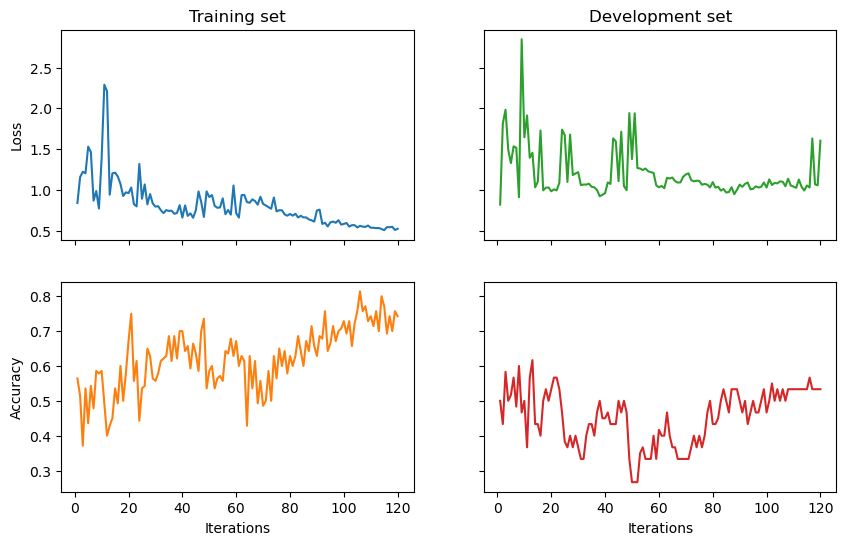

In [13]:
import matplotlib.pyplot as plt
fig, ((ax_tl, ax_tr), (ax_bl, ax_br)) = plt.subplots(2, 2, sharex=True, sharey='row', figsize=(10, 6))
ax_tl.set_title('Training set')
ax_tr.set_title('Development set')
ax_bl.set_xlabel('Iterations')
ax_br.set_xlabel('Iterations')
ax_bl.set_ylabel('Accuracy')
ax_tl.set_ylabel('Loss')

colours = iter(plt.rcParams['axes.prop_cycle'].by_key()['color'])
range_ = np.arange(1, trainer.epochs + 1)
ax_tl.plot(range_, trainer.train_epoch_costs, color=next(colours))
ax_bl.plot(range_, trainer.train_eval_results['acc'], color=next(colours))
ax_tr.plot(range_, trainer.val_costs, color=next(colours))
ax_br.plot(range_, trainer.val_eval_results['acc'], color=next(colours))

Now we have trained our model, we can save it for further use.

In [91]:
model.save('model.lt')